<a href="https://colab.research.google.com/github/sr-bn98/skills-copilot-codespaces-vscode/blob/main/_proj_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Classification Model Trained on 2D MRI Slices

This dataset contains brain MR images together with manual FLAIR abnormality segmentation masks.
The images were obtained from The Cancer Imaging Archive (TCIA).
They correspond to 110 patients included in The Cancer Genome Atlas (TCGA) lower-grade glioma collection with at least fluid-attenuated inversion recovery (FLAIR) sequence and genomic cluster data available ([link](https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation/code )).

T4 GPU of google colab is used for this session.

**Import Libraries and Installing required libraries**

I use NumPy, Pandas, OpenCV, and scikit-learn for data manipulation, preprocessing, and splitting. For visualizing data and results I use Matplotlib. And finally use Pytorch to build and train deep learning models with various layers and callbacks.

In [ ]:
!pip install segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 40.1 MB/s eta 0:00:00


In [ ]:

import os
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from glob import glob
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

from rich.console import Console
from rich.table import Table

import torch
import torchvision.transforms as transforms
from PIL import Image
from torchmetrics import Dice
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset , DataLoader ,  random_split
import torchvision.transforms as transforms

I also set a seed for reproducibility and consistent results across runs:

In [ ]:



seed = 40
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


# Dataset Familiarization

The dataset is located at https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation/code Each patient has a folder containing images and masks.

In [ ]:
#from google.colab import files
#files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation



cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation
License(s): CC-BY-NC-SA-4.0
100% 712M/714M [00:32<00:00, 24.6MB/s]
100% 714M/714M [00:32<00:00, 23.1MB/s]


In [ ]:
!unzip lgg-mri-segmentation.zip  > /dev/null 2>&1

!rm -rf lgg-mri-segmentation.zip

There is a folder for each patient, containing images and masks.

In [ ]:
dataset_path = '/content/kaggle_3m'

patients = os.listdir(dataset_path)
print(f"Total patients in the dataset: {len(patients)}")

Total patients in the dataset: 112


I explore the files in a sample patient's folder to understand the dataset structure, where each patient's image is in .tif format, and the corresponding mask file ends with _mask in its name.

In [ ]:
example_patient = random.choice(patients)
example_patient_path = os.path.join(dataset_path, example_patient)
print(f"Files in {example_patient}:")
print(os.listdir(example_patient_path))

Files in TCGA_HT_7475_19970918:
['TCGA_HT_7475_19970918_25.tif', 'TCGA_HT_7475_19970918_29_mask.tif', 'TCGA_HT_7475_19970918_15_mask.tif', 'TCGA_HT_7475_19970918_10.tif', 'TCGA_HT_7475_19970918_14_mask.tif', 'TCGA_HT_7475_19970918_12.tif', 'TCGA_HT_7475_19970918_23.tif', 'TCGA_HT_7475_19970918_2.tif', 'TCGA_HT_7475_19970918_17.tif', 'TCGA_HT_7475_19970918_6.tif', 'TCGA_HT_7475_19970918_1.tif', 'TCGA_HT_7475_19970918_11.tif', 'TCGA_HT_7475_19970918_26.tif', 'TCGA_HT_7475_19970918_24_mask.tif', 'TCGA_HT_7475_19970918_31_mask.tif', 'TCGA_HT_7475_19970918_7.tif', 'TCGA_HT_7475_19970918_5_mask.tif', 'TCGA_HT_7475_19970918_15.tif', 'TCGA_HT_7475_19970918_4.tif', 'TCGA_HT_7475_19970918_17_mask.tif', 'TCGA_HT_7475_19970918_11_mask.tif', 'TCGA_HT_7475_19970918_13.tif', 'TCGA_HT_7475_19970918_26_mask.tif', 'TCGA_HT_7475_19970918_3_mask.tif', 'TCGA_HT_7475_19970918_21_mask.tif', 'TCGA_HT_7475_19970918_23_mask.tif', 'TCGA_HT_7475_19970918_18.tif', 'TCGA_HT_7475_19970918_7_mask.tif', 'TCGA_HT_7475_

Then, I'll get image and mask paths for the example patient:

In [ ]:
def get_image_mask_paths(patient_path):
    image_paths = glob(os.path.join(patient_path, '*.tif'))
    mask_paths = [path for path in image_paths if 'mask' in os.path.basename(path)]
    image_paths = [path for path in image_paths if 'mask' not in os.path.basename(path)]
    return image_paths, mask_paths

image_paths, mask_paths = get_image_mask_paths(example_patient_path)
print(f"Number of images: {len(image_paths)}, Number of masks: {len(mask_paths)}")

Number of images: 32, Number of masks: 32


# Display 10 Images and Their Corresponding Masks
I've randomly selected 10 images and their corresponding mask paths
Each image is read and converted to Grayscale format and masks are read in Grayscale format.

Contours from the mask are extracted using cv2.findContours and overlaid on the image in red using cv2.drawContours.

The visualization is arranged in three columns:  image,  mask, and the Image with highlighted mask.

(256, 256)
(256, 256, 3)
(256, 256)
(256, 256, 3)
(256, 256)
(256, 256, 3)
(256, 256)
(256, 256, 3)
(256, 256)
(256, 256, 3)
(256, 256)
(256, 256, 3)
(256, 256)
(256, 256, 3)
(256, 256)
(256, 256, 3)
(256, 256)
(256, 256, 3)
(256, 256)
(256, 256, 3)


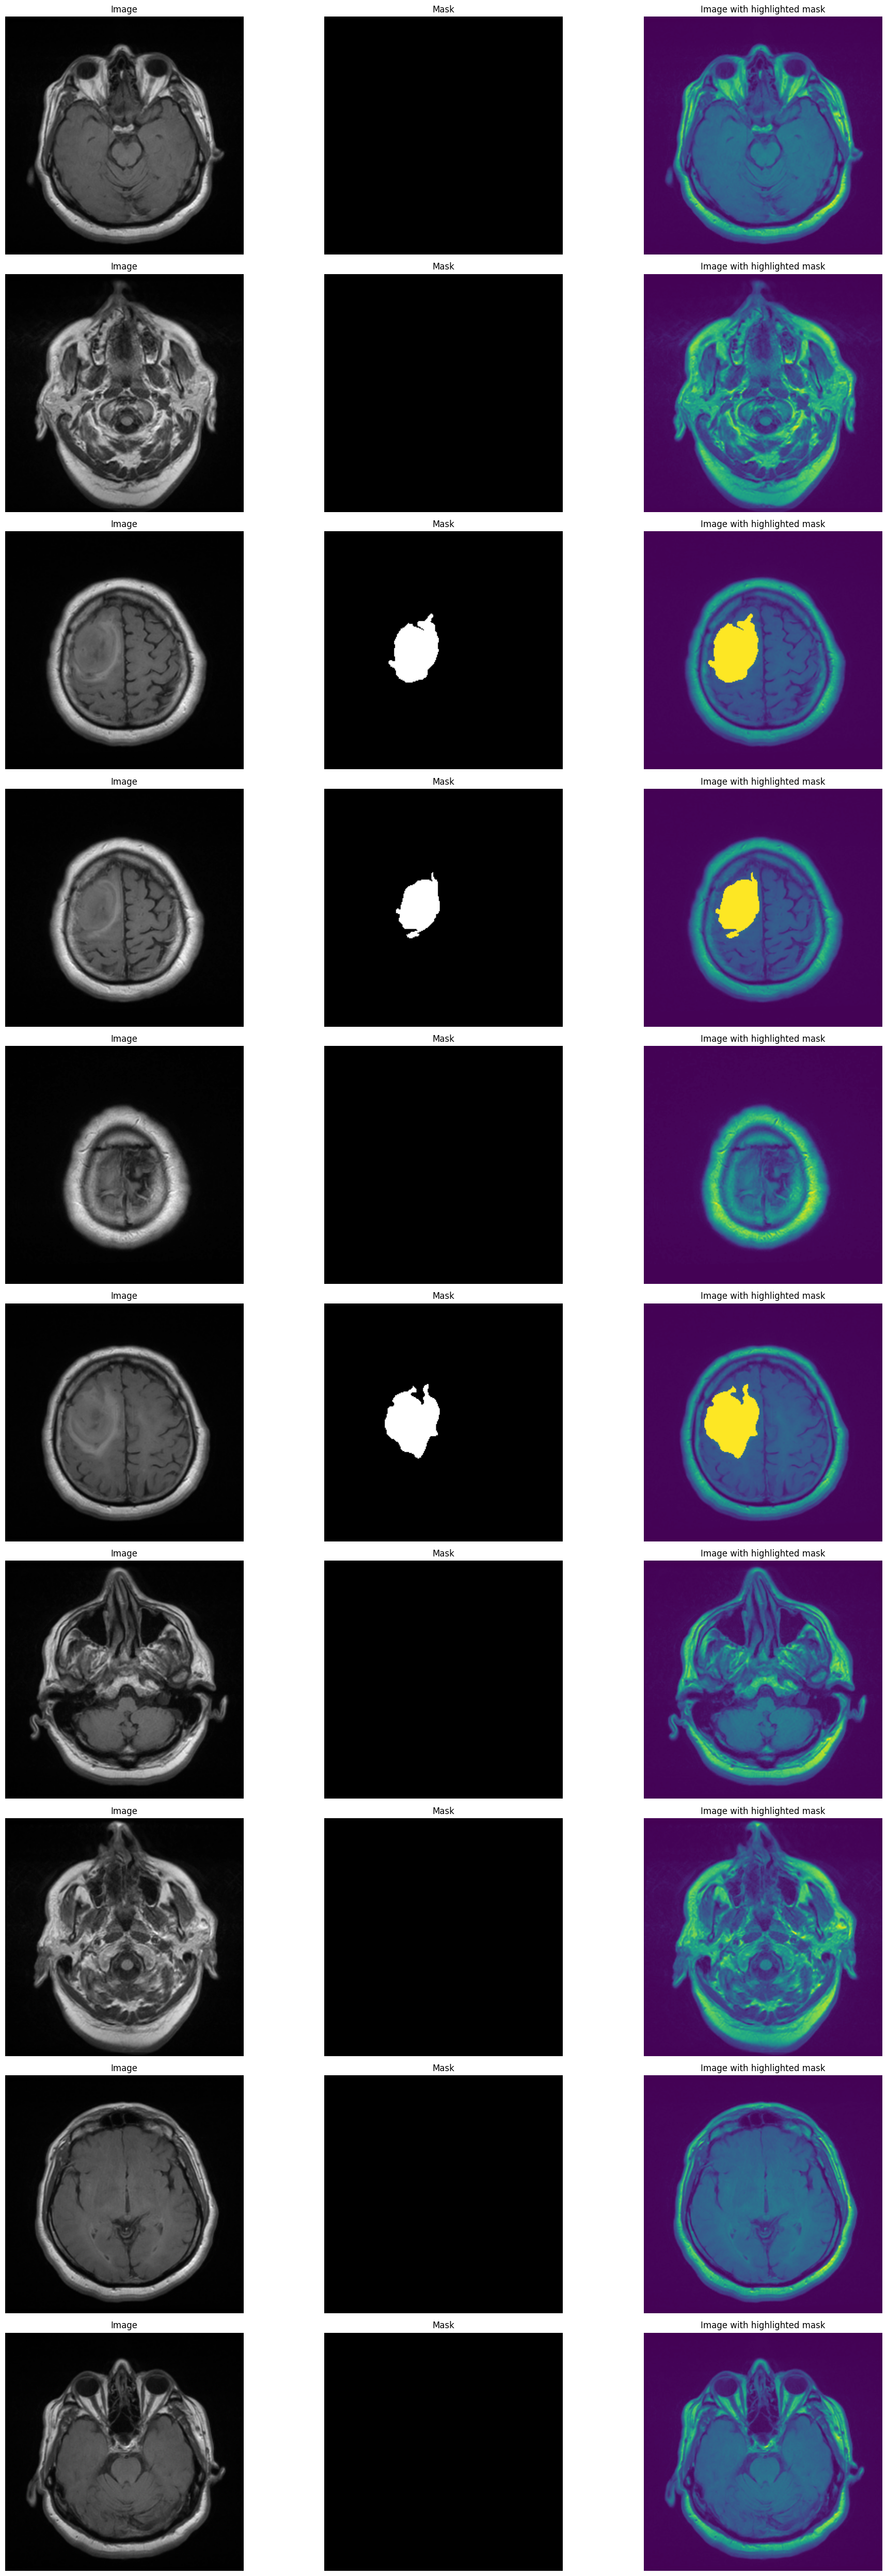

In [ ]:
num_images_to_display = 10
selected_image_paths = random.sample(image_paths, num_images_to_display)
selected_mask_paths = [path.replace('.tif', '_mask.tif') for path in selected_image_paths]

plt.figure(figsize=(20, 5 * num_images_to_display))

for i, (img_path, mask_path) in enumerate(zip(selected_image_paths, selected_mask_paths)):
    # Read the image and mask
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)

    # Plot image
    plt.subplot(num_images_to_display, 3, 3 * i + 1)
    plt.imshow(img, cmap='gray')
    plt.title('Image')
    plt.axis('off')
    print(img.shape)

    # Plot mask
    plt.subplot(num_images_to_display, 3, 3 * i + 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    plt.axis('off')
    print(mask.shape)

    # Plot image with highlighted mask
    img_copy = img.copy()
    contours, hier = cv2.findContours(mask[:, :, 0], cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    mask_over_image = cv2.drawContours(img_copy, contours, -1, [255, 0, 0], thickness=-1)
    plt.subplot(num_images_to_display, 3, 3 * i + 3)
    plt.imshow(mask_over_image)
    plt.title('Image with highlighted mask')
    plt.axis('off')

plt.tight_layout()
plt.show()

now i read an image and a mask from their respective file paths and displays basic statistics for both, such as their dimensions, the range of pixel values, and the unique values in the mask (which can be useful to identify different classes or labels in the mask)

In [ ]:
def display_statistics(image_path, mask_path):
    image = plt.imread(image_path)
    mask = plt.imread(mask_path)

    print("Image Statistics:")
    print(f"Shape: {image.shape}")
    print(f"Min value: {image.min()}")
    print(f"Max value: {image.max()}")

    print("\nMask Statistics:")
    print(f"Shape: {image.shape}")
    print(f"Min value: {image.min()}")
    print(f"Max value: {image.max()}")
    print(f"Unique values: {np.unique(mask)}")

display_statistics(image_paths[0], mask_paths[0])

Image Statistics:
Shape: (256, 256, 3)
Min value: 0
Max value: 235

Mask Statistics:
Shape: (256, 256, 3)
Min value: 0
Max value: 235
Unique values: [  0 255]


#  Preprocessing
**Implement Image Preprocessing Techniques**

I defined a function to load and preprocess images and their corresponding masks from the dataset and convert them to 'png' format.

because of RAM limitation, i used 3 patients


Read the image in RGB, resize to 128x128, normalize.


Read the mask in grayscale, resize to 128x128, normalize.


Also i used tqdm library to display progress bars for loops. In the code, it wraps the for loop over patient_ids to show how many patient folders have been processed.


In [ ]:




def convert_tiff_to_png(tiff_path, output_path):
    """Convert TIFF file to PNG format."""
    tiff_image = Image.open(tiff_path)
    tiff_image.save(output_path, "PNG")
    print(f"Converted {tiff_path} to {output_path}")

def load_and_preprocess_data(data_path):


    img_png = []
    seg_png = []
    folder_ids = os.listdir(data_path)[:3]
    for folder_id in tqdm(folder_ids, desc='Preprocessing Images and Masks'):
        folder_path = os.path.join(data_path, folder_id)
        image_paths, _ = get_image_mask_paths(folder_path)
        for img_path in image_paths:
            mask_path = img_path.replace('.tif', '_mask.tif')
            new_img_path = img_path.replace('.tif', '.png')
            new_mask_path = mask_path.replace('.tif', '.png')

            convert_tiff_to_png(img_path, new_img_path)
            convert_tiff_to_png(mask_path, new_mask_path)

            img_png.append(new_img_path)
            seg_png.append(new_mask_path)





    return img_png , seg_png


In [ ]:




class CustomImageDataset(Dataset):
    def __init__(self, image_path, mask_path, image_transform=None, mask_transform=None):
        self.image_path = image_path
        self.mask_path = mask_path
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, idx):
        img_path = self.image_path[idx]
        mask_path = self.mask_path[idx]
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask


image_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

mask_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])


img_png,seg_png=load_and_preprocess_data('/content/kaggle_3m')

custom_dataset = CustomImageDataset(img_png,seg_png, image_transform=image_transform ,mask_transform=mask_transform )



Preprocessing Images and Masks:   0%|          | 0/3 [00:00<?, ?it/s]

Converted /content/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_2.tif to /content/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_2.png
Converted /content/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_2_mask.tif to /content/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_2_mask.png
Converted /content/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_22.tif to /content/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_22.png
Converted /content/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_22_mask.tif to /content/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_22_mask.png
Converted /content/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_10.tif to /content/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_10.png
Converted /content/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_10_mask.tif to /content/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_10_mask.png
Converted /content/kaggle_3m/TCGA_CS_6186_20000601/TCGA_

# Split the Dataset into Train and Test Sets

split into train and test (train is 80%, test is 20%)

In [ ]:
from torch.utils.data import random_split


train_size = int(0.8 * len(custom_dataset))
test_size = len(custom_dataset) - train_size


train_ds, test_ds = random_split(custom_dataset, [train_size, test_size])


# Set Dataloader

In [ ]:
train_loader = DataLoader(dataset=train_ds, batch_size=16, shuffle=True)

#  Visualization
This function is to show 5 patients from our datasets, so that we can see if the it is okay or we need
to change/delete something.





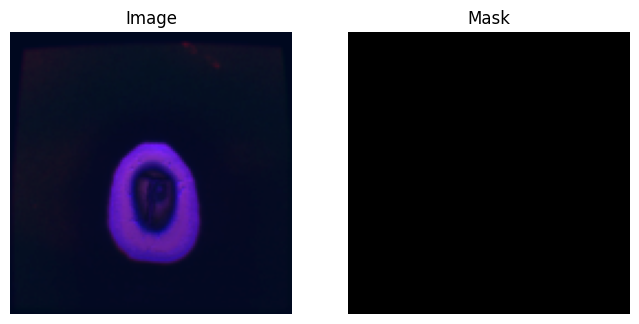

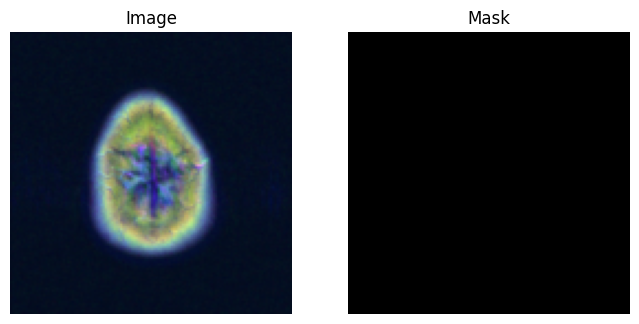

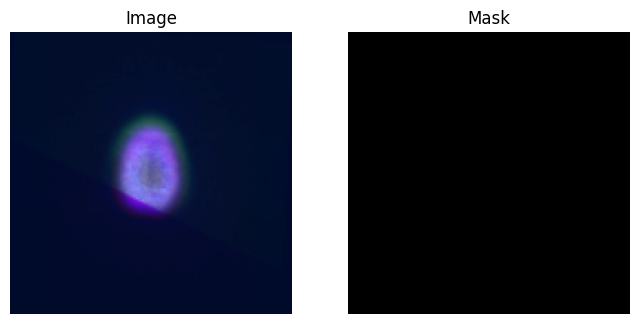

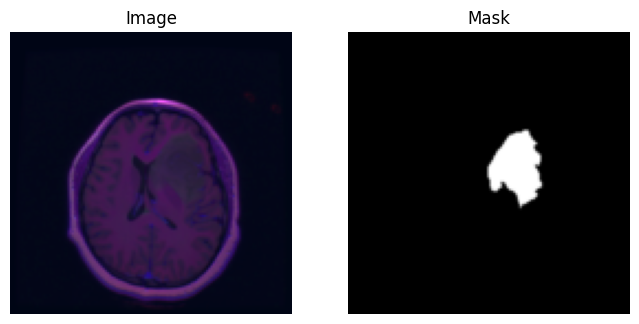

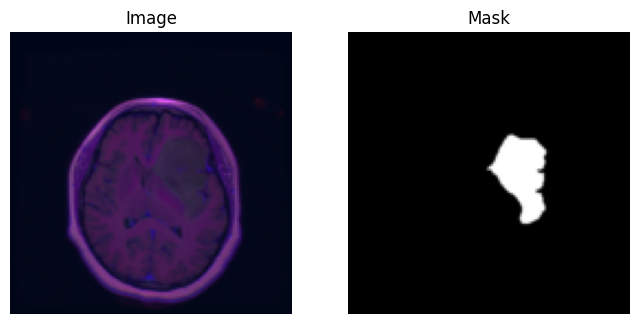

In [ ]:


num_samples_to_display = 5
samples_displayed = 0

for images, masks in train_loader:
    for i in range(images.shape[0]):
        img = images[i].cpu().numpy().transpose(1, 2, 0)
        mask = masks[i].cpu().numpy().squeeze()
        img = (img - img.min()) / (img.max() - img.min())

        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title('Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='gray')
        plt.title('Mask')
        plt.axis('off')

        plt.show()

        samples_displayed += 1
        if samples_displayed >= num_samples_to_display:
            break

    if samples_displayed >= num_samples_to_display:
        break


# Define our Model

In [ ]:

model = smp.Unet(
    encoder_name="resnet34",
    in_channels=3,
    classes=1,
    activation='sigmoid'
)




Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 296MB/s]


# Set our Optimizer and Loss function and Metrics

In [ ]:

optimizer = optim.Adam(model.parameters(), lr=0.001)



In [ ]:

class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

        return 1 - dice


dice_metric = Dice()

In [ ]:
!mkdir '/content/model'

# Our Training Process

In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    train_loss = 0.0
    dice_metric = Dice().to(device)

    for images, masks in tqdm(train_loader):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

        dice_metric.update(outputs, masks.int())

    train_loss /= len(train_loader.dataset)
    dice_score = dice_metric.compute().item()

    return train_loss, dice_score

def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    dice_metric = Dice().to(device)

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)

            dice_metric.update(outputs, masks.int())

    val_loss /= len(val_loader.dataset)
    dice_score = dice_metric.compute().item()

    return val_loss, dice_score

In [ ]:
def train_and_validate(train_dataset,val_dataset,
                       model, device, num_epochs, batch_size):

    train_dataset = train_dataset
    val_dataset =val_dataset
    import torch


    model_save_path = '/content/model.pth'


    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    model = model.to(device)
    criterion = DiceLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    train_dices = []
    val_dices = []

    for epoch in range(num_epochs):
        train_loss, train_dice = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_dice = validate_one_epoch(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_dices.append(train_dice)
        val_dices.append(val_dice)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Dice: {train_dice:.4f}, Val Dice: {val_dice:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_save_path)

    return train_losses, val_losses, train_dices, val_dices

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device...')

train_losses, val_losses, train_dices, val_dices = train_and_validate(
    train_ds,
    test_ds,
    model,
    device,
    num_epochs=20,
    batch_size=16
)

Using cuda device...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1/20, Train Loss: 0.9717, Val Loss: 0.9661, Train Dice: 0.0294, Val Dice: 0.0270


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2/20, Train Loss: 0.9570, Val Loss: 0.9343, Train Dice: 0.0985, Val Dice: 0.0794


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3/20, Train Loss: 0.9453, Val Loss: 0.9241, Train Dice: 0.1466, Val Dice: 0.1359


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4/20, Train Loss: 0.9297, Val Loss: 0.8921, Train Dice: 0.2398, Val Dice: 0.2303


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5/20, Train Loss: 0.9034, Val Loss: 0.8706, Train Dice: 0.2404, Val Dice: 0.2564


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6/20, Train Loss: 0.8713, Val Loss: 0.9143, Train Dice: 0.3577, Val Dice: 0.0916


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7/20, Train Loss: 0.8157, Val Loss: 0.8941, Train Dice: 0.4713, Val Dice: 0.1113


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8/20, Train Loss: 0.7359, Val Loss: 0.6488, Train Dice: 0.5006, Val Dice: 0.5828


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9/20, Train Loss: 0.6599, Val Loss: 0.8938, Train Dice: 0.5796, Val Dice: 0.0927


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10/20, Train Loss: 0.5078, Val Loss: 0.8555, Train Dice: 0.6722, Val Dice: 0.1285


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 11/20, Train Loss: 0.3639, Val Loss: 0.3549, Train Dice: 0.7525, Val Dice: 0.6747


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 12/20, Train Loss: 0.3611, Val Loss: 0.4113, Train Dice: 0.7406, Val Dice: 0.7046


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 13/20, Train Loss: 0.3517, Val Loss: 0.5599, Train Dice: 0.7523, Val Dice: 0.3983


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 14/20, Train Loss: 0.2447, Val Loss: 0.4996, Train Dice: 0.7447, Val Dice: 0.5724


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 15/20, Train Loss: 0.2656, Val Loss: 0.2434, Train Dice: 0.7712, Val Dice: 0.6948


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 16/20, Train Loss: 0.2164, Val Loss: 0.3369, Train Dice: 0.8087, Val Dice: 0.6957


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 17/20, Train Loss: 0.3036, Val Loss: 0.1776, Train Dice: 0.7598, Val Dice: 0.7847


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 18/20, Train Loss: 0.2002, Val Loss: 0.1827, Train Dice: 0.8104, Val Dice: 0.8017


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 19/20, Train Loss: 0.2616, Val Loss: 0.1631, Train Dice: 0.7775, Val Dice: 0.8515


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 20/20, Train Loss: 0.1847, Val Loss: 0.2294, Train Dice: 0.8294, Val Dice: 0.8067


# Resuls and Analysis

In [ ]:
def plot_progress(train_losses, val_losses, train_dices, val_dices):
    num_epochs = len(train_losses)
    plt.figure(figsize=(12, 6))


    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), train_dices, label='Train Dice')
    plt.plot(range(1, num_epochs+1), val_dices, label='Val Dice')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Score')
    plt.title('Training and Validation Dice Scores')
    plt.legend()

    plt.tight_layout()
    plt.savefig('/content/model')
    plt.show()

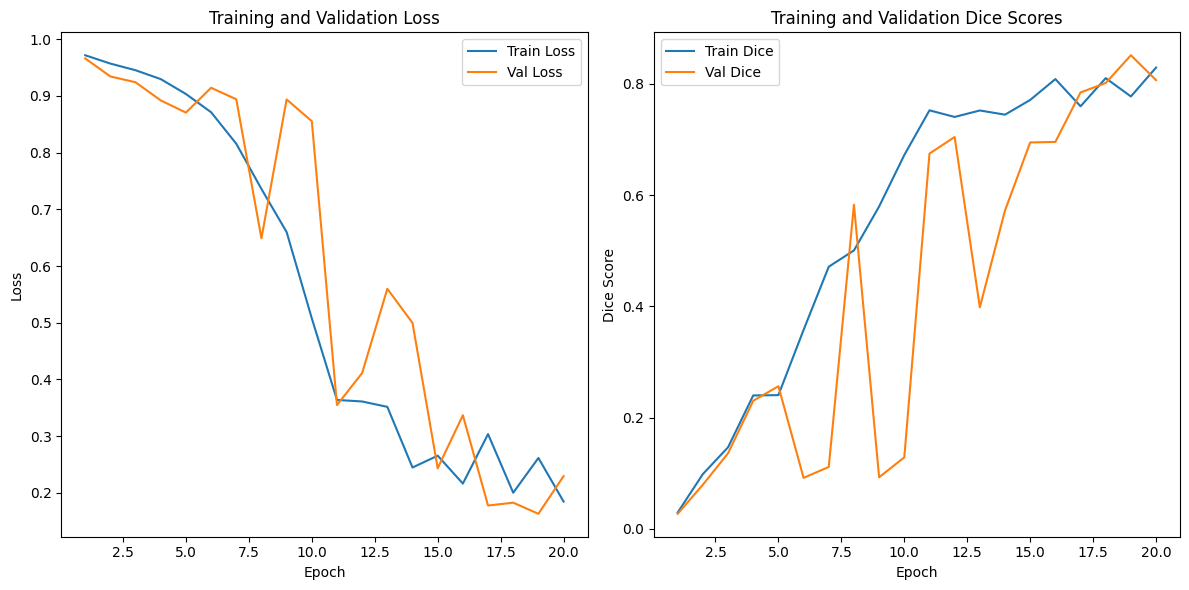

In [ ]:
plot_progress(train_losses, val_losses, train_dices, val_dices)

In [ ]:
best_model = smp.Unet(
    encoder_name="resnet34",
    in_channels=3,
    classes=1,
    activation='sigmoid'
)
state_dict = torch.load('/content/model.pth')
best_model.load_state_dict(state_dict)
best_model = best_model.to(device)
criterion = DiceLoss()


test_loader = DataLoader(
    test_ds,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_loss, test_dice = validate_one_epoch(
    best_model, test_loader, criterion, device
)

print(f'Test loss: {test_loss:.4f}')
print(f'Test dice: {test_dice:.4f}')


<ipython-input-27-412bb4c027f0>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/content/model.pth')


Test loss: 0.1615
Test dice: 0.8515


# Display 5 Test Images, Ground Truths, and Their Corresponding Generated Masks

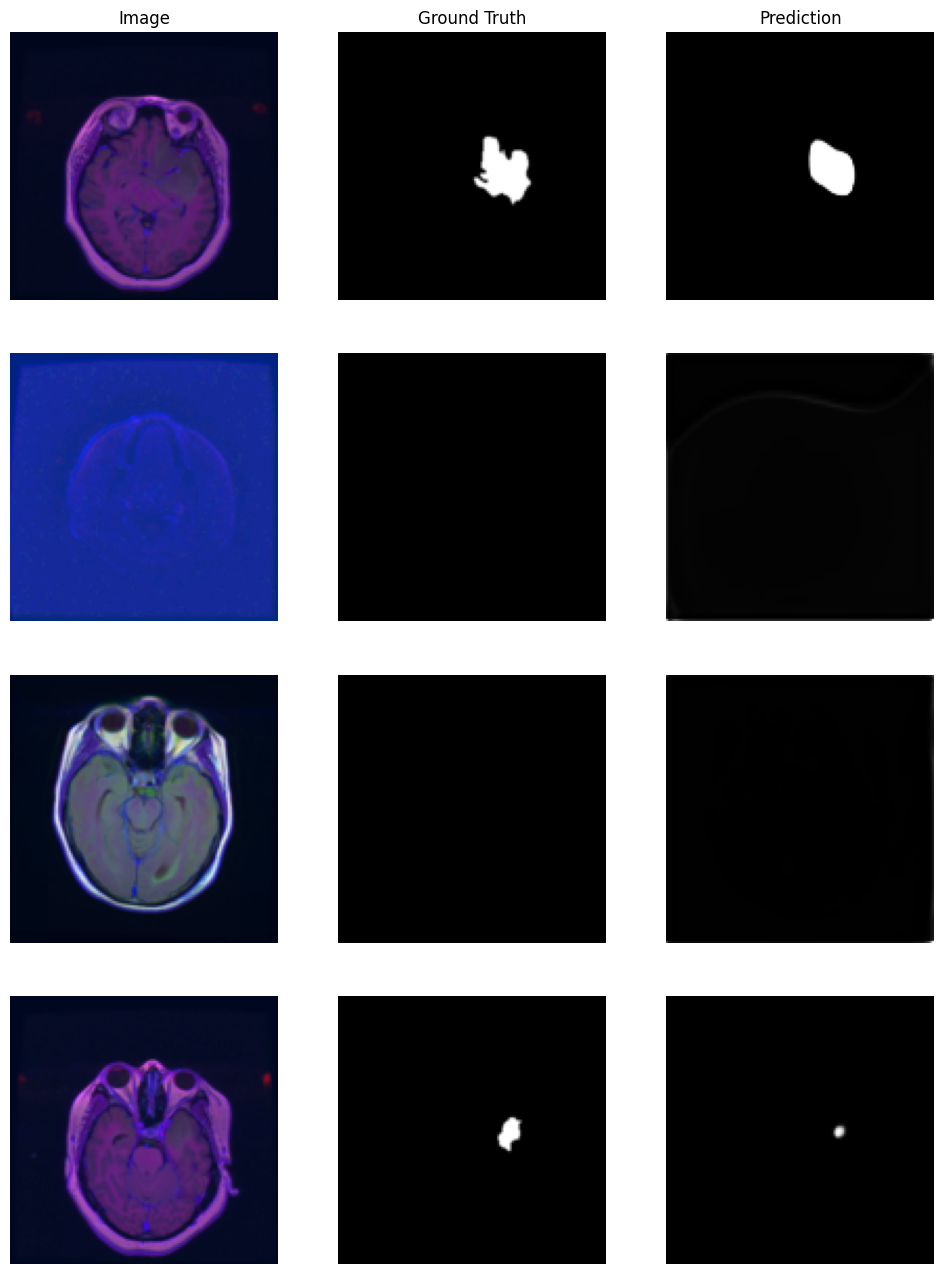

In [ ]:

num_samples_to_display = 5
samples_displayed = 0


for images, masks in test_loader:
    images, masks = images.to(device), masks.to(device)
    outputs = best_model(images)

    fig, axs = plt.subplots(4, 3, figsize=(12, 16))
    axs[0, 0].set_title('Image')
    axs[0, 1].set_title('Ground Truth')
    axs[0, 2].set_title('Prediction')

    for i in range(4):
        if samples_displayed >= num_samples_to_display:
            break

        img = images[i].cpu().numpy().transpose(1, 2, 0)
        mask = masks[i].cpu().numpy().squeeze()
        img = (img - img.min()) / (img.max() - img.min())
        pred = outputs[i].cpu().detach().numpy().squeeze()

        axs[i, 0].imshow(img)
        axs[i, 1].imshow(mask, cmap='gray')
        axs[i, 2].imshow(pred, cmap='gray')

        for j in range(3):
            axs[i, j].axis('off')

        samples_displayed += 1

    break
